In [1]:
%matplotlib  inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from franke import FrankeFunction, FrankePlot
from mpl_toolkits.mplot3d import Axes3D
import tools

In [3]:
seed = 12345
x,y,z,noise = tools.generate_data(N = 1000, seed = seed)
deg = 5

from tools import get_X_poly2D, fit_poly2D
regr = fit_poly2D(x, y, z, deg = deg, lmbd = 0)

zhat = regr.yhat
beta = regr.beta
beta

array([  0.38267453,   4.12415499,   7.85861398, -11.26653785,
       -14.60087479, -34.53732562,  -0.90652168,  18.57623836,
        46.01250749,  47.91880463,  21.33840132, -28.32786465,
        -6.7988584 , -56.08504678, -22.35571824, -13.51228625,
        16.78849056,  -6.41055131,  11.18184941,  19.94986743,   0.74100692])

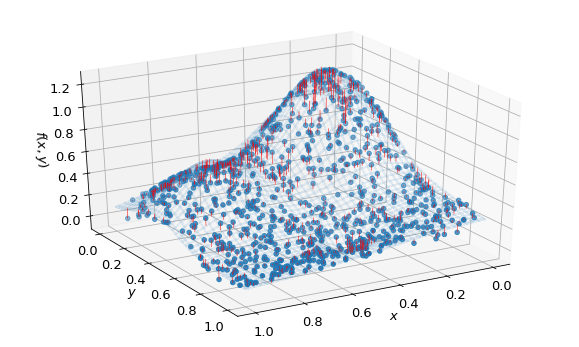

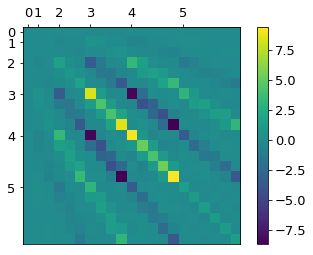

In [4]:
from plotting import plot_data_3D, plot_covar
plot_data_3D(x,y,z,zhat, beta)
plot_covar(regr,5)

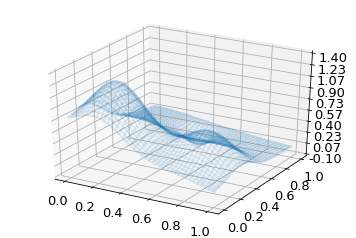

In [5]:
FrankePlot()

In [343]:
X = get_X_poly2D(x,y,deg = 5)
regr.betaVar.shape, X.shape, zhat.shape

((21, 21), (1000, 21), (1000,))

In [403]:
l0  = X[0]
l0.dot(regr.betaVar) @ l0

2.2268817358047629e-05

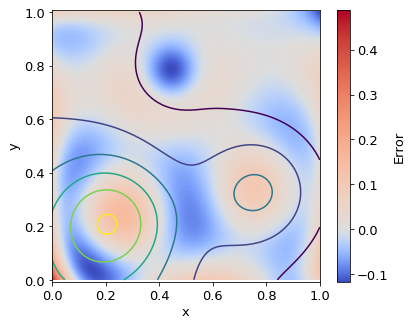

In [396]:
fig, zerr = contour_plot(regr)

In [397]:
z_gt = FrankeFunction(x,y)
zerr = (zhat-z_gt)**2

In [398]:
var = np.diag(((X.dot(regr.betaVar)) @ X.T))

bias = zerr - var - noise**2
bias

array([  2.25992709e-04,   6.91508676e-04,   5.37491512e-04,
         1.51793559e-05,   8.15862086e-04,  -1.30116436e-04,
        -1.31398841e-04,   4.64526386e-03,   2.11063559e-03,
         5.67734246e-03,  -1.37280716e-04,   2.22719952e-03,
         3.34492710e-04,   1.09849174e-05,   6.62479598e-05,
         2.45490743e-04,   2.53972437e-04,   1.16493927e-02,
         1.59698673e-03,  -1.08216771e-04,  -1.13382471e-04,
        -1.26111144e-04,  -1.33010010e-04,  -1.38410703e-04,
         1.21012735e-02,  -1.33136459e-04,  -1.16117324e-04,
         1.82156934e-04,   4.37153681e-05,   1.26411172e-02,
         2.32801034e-03,  -1.02144065e-04,   8.57078786e-04,
        -1.16310390e-04,   2.07510496e-04,   3.16306006e-05,
         5.91623101e-04,   1.50298205e-04,   3.92486977e-03,
        -1.12571041e-04,   7.43703929e-03,   6.69390698e-04,
        -1.17287402e-04,   1.84360681e-02,  -1.49162200e-04,
         3.90890516e-04,   1.25358756e-03,   6.72838709e-05,
         6.68370131e-04,

/home/halvard/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


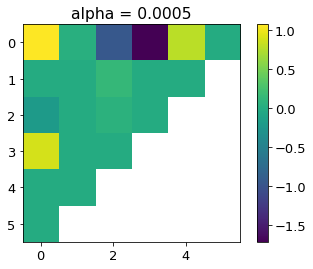

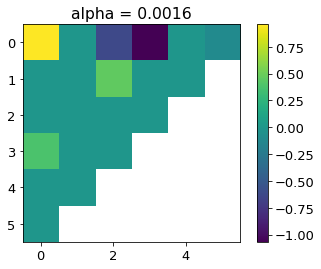

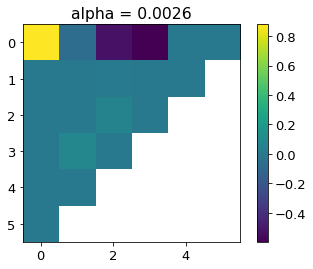

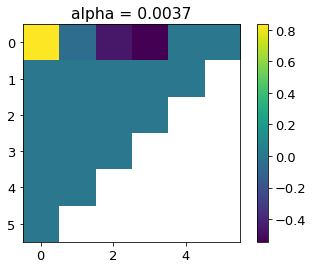

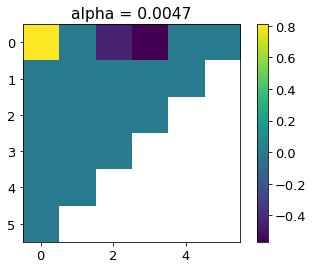

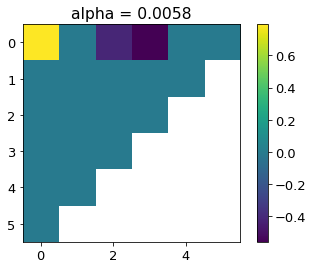

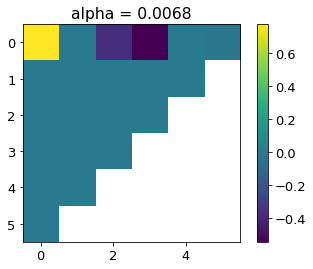

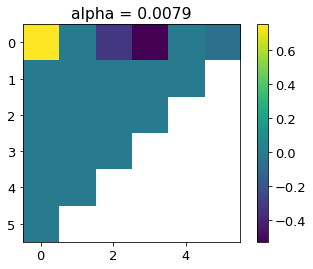

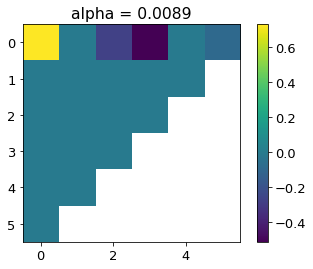

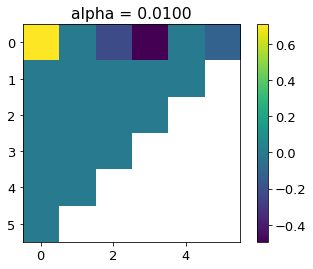

In [539]:
from plotting import contour_plot
from sklearn.linear_model import Lasso

X = get_X_poly2D(x, y, deg = deg)
z_gt = FrankeFunction(x,y)

for alpha in np.linspace(0.0005, 0.010, 10):
    regr = Lasso( alpha = alpha ,fit_intercept = False)
    regr.fit(X, z)

    beta = regr.coef_
    
    zhat = regr.predict(X)
    
    df_exps = tools.get_exp_coeffs(beta, deg = 5, print_beta=False)
    plt.figure()
    plt.title('alpha = {:.4f}'.format(alpha))
    m = plt.imshow(df_exps)
    plt.colorbar(m)
#     fig = contour_plot(regr, plot_err = True)
#     print('total feil: {}'.format(np.sum(np.abs(zhat - z_gt))))
#     fig.suptitle('alpha = {:.4f}'.format(alpha))

In [505]:
symX = X.T @ X
N = symX.shape[0]
lmbd = 0.1

from scipy import linalg
beta = linalg.inv(symX + lmbd*np.eye(N)) @ X.T @ z

beta

array([ 1.04948433,  0.31587174, -0.59975137, -2.37211183,  1.06348865,
       -1.30871314, -0.31673332, -0.53403607,  0.7794553 ,  0.66725102,
        0.92394962, -0.22067446, -0.15441648,  0.49624127,  0.74632533,
        0.80436718,  0.07710595, -0.13821876, -0.19922415, -0.35494877,
       -0.60611638])

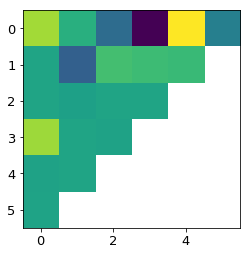

In [534]:
df_exps = tools.get_exp_coeffs(beta, deg = 5, print_beta = False)
plt.imshow(df_exps)

      c:  1.08
    y^1:  0.18
    y^2: -0.90
    y^3: -2.28
    y^4:  1.63
    y^5: -0.59
x^1 y^1: -1.08
x^1 y^2:  0.46
x^1 y^3:  0.39
x^1 y^4:  0.37
   x^2 : -0.00
x^2 y^1: -0.06
   x^3 :  1.05
x^3 y^2: -0.02
   x^4 : -0.03
   x^5 : -0.02


/home/halvard/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


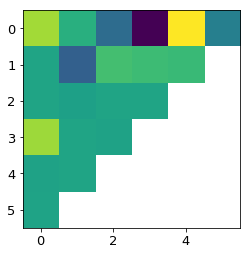

In [529]:
plt.imshow(df_exps)